In [43]:
import math
import torch
import numpy as np
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED=3407
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [2]:
from imputation_model import *
from train import *
from utils import *
from losses import *

In [3]:
import scanpy as sc
from scipy import sparse

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
def e2eImpute(adata,
              project='AE',
              imputation='GAE',
              k=3,
              distance='hyperbolic',
              z_dim=64,
              y_dim=128,
              pro_dim1=128,
              pro_dim2=1024,
              use_raw=True,
              no_cuda=False,
              epochs=1000,
              lr=0.001,
              weight_decay=0.0005,
              patience=200,
              alpha=0.1,
              beta=0.9,
              gamma=0.5,
              fastmode=False,
              verbose=True):
    
    adata = adata.copy()
    #adata = normalize(adata, filter_min_counts=False)
    
    true_values=torch.tensor(adata.raw.X.A, dtype=torch.float).to(device)
    size_factors = 1.0
    
    data=torch.tensor(adata.X.toarray(), dtype=torch.float).to(device)
    model=IntegratedModel(data,size_factors=size_factors, project=project, imputation=imputation, k=k, distance=distance,
                         z_dim=z_dim, y_dim=y_dim, pro_dim1=pro_dim1, pro_dim2=pro_dim2, use_raw=use_raw).to(device)
    
    print(model)

    train(data=data, true_values=true_values, model=model,
          project=project, imputation=imputation, no_cuda=no_cuda, epochs=epochs, lr=lr, weight_decay=weight_decay,
          patience=patience, alpha=alpha, beta=beta,gamma=gamma, fastmode=fastmode, verbose=verbose)

    
    if project == 'AE' and imputation == 'GAE':
        output_mlp, pred = model(data)
        result = pred.detach().cpu()
    if project == 'AE' and imputation == 'ZINBGAE':
        output_mlp, pred, z_mean, z_dropout, z_dispersion = model(data)
        result = pred.detach().cpu()
    if project == 'ZINBAE' and imputation == 'GAE':
        output_mlp, _, _, _, pred = model(data)
        result = pred.detach().cpu()
    if project == 'ZINBAE' and imputation == 'ZINBGAE':
        output_mlp, _, _, _, pred, _, _, _ = model(data)
        result = pred.detach().cpu()

    return result

In [5]:
def pearsonr_error(y, h):
    res = []
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))

    for i in range(y.shape[0]):
        res.append(pearsonr(y[i], h[i])[0])
    return np.mean(res)


def cosine_similarity_score(y, h):
    if len(y.shape) < 2:
        y = y.reshape((1, -1))
        h = h.reshape((1, -1))
    cos = cosine_similarity(y, h)
    res = []
    for i in range(len(cos)):
        res.append(cos[i][i])
    return np.mean(res)

In [60]:
adata = sc.read_h5ad('./data/Klein_top2000/masked/Klein_top2000_00.h5ad')

In [61]:
%%time
result = e2eImpute(adata=adata,
                    project='ZINBAE', #AE ZINBAE
                    imputation='GAE', #GAE ZINBGAE
                    k=3,
                    distance='hyperbolic', #euclidean, manhattan, hyperbolic, cosine
                    z_dim=128,
                    y_dim=1024,
                    pro_dim1=128,
                    pro_dim2=1024,
                    use_raw=True,
                    no_cuda=False,
                    epochs=25000,
                    lr=0.0005, 
                    weight_decay=0,
                    patience=200,
                    alpha=0.0001,
                    beta=0.2,
                    gamma=0.1,
                    fastmode=False,
                    verbose=True)

IntegratedModel(
  (mlp): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=2000, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=128, out_features=2000, bias=True)
    )
  )
  (zinbae): ZINBAE(
    (enc1): Linear(in_features=2000, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dr1): Dropout(p=0.2, inplace=False)
    (mean_act): MeanAct()
    (disp_act): DispAct()
    (pi_act): Sigmoid()
    (dense2_mean): Linear(in_features=128, out_features=2000, bias=True)
    (dense2_disp): Linear(in_features=128, out_features=2000, bias=True)
    (dense2_pi): Linear(in_features=128, out_features=2000, bias=True)
    (dec1): Linear(in_features=2000, out_features=1024, bias=True)
    (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dr2): Dropout(p=0.4, inplace=False)
    (dec2): Linear(in_features=1024, out_features=20

Epoch: 2020 loss_train: 15.9799
Epoch: 2030 loss_train: 15.9280
Epoch: 2040 loss_train: 15.8797
Epoch: 2050 loss_train: 15.8275
Epoch: 2060 loss_train: 15.7753
Epoch: 2070 loss_train: 15.7246
Epoch: 2080 loss_train: 15.6742
Epoch: 2090 loss_train: 15.6245
Epoch: 2100 loss_train: 15.5758
Epoch: 2110 loss_train: 15.5270
Epoch: 2120 loss_train: 15.4771
Epoch: 2130 loss_train: 15.4261
Epoch: 2140 loss_train: 15.3771
Epoch: 2150 loss_train: 15.3279
Epoch: 2160 loss_train: 15.2789
Epoch: 2170 loss_train: 15.2309
Epoch: 2180 loss_train: 15.1827
Epoch: 2190 loss_train: 15.1337
Epoch: 2200 loss_train: 15.0851
Epoch: 2210 loss_train: 15.0373
Epoch: 2220 loss_train: 14.9890
Epoch: 2230 loss_train: 14.9401
Epoch: 2240 loss_train: 14.8923
Epoch: 2250 loss_train: 14.8448
Epoch: 2260 loss_train: 14.7986
Epoch: 2270 loss_train: 14.7510
Epoch: 2280 loss_train: 14.7041
Epoch: 2290 loss_train: 14.6561
Epoch: 2300 loss_train: 14.6101
Epoch: 2310 loss_train: 14.5623
Epoch: 2320 loss_train: 14.5168
Epoch: 2

Epoch: 4620 loss_train: 7.4228
Epoch: 4630 loss_train: 7.4155
Epoch: 4640 loss_train: 7.3895
Epoch: 4650 loss_train: 7.3704
Epoch: 4660 loss_train: 7.3559
Epoch: 4670 loss_train: 7.3376
Epoch: 4680 loss_train: 7.3217
Epoch: 4690 loss_train: 7.3061
Epoch: 4700 loss_train: 7.2878
Epoch: 4710 loss_train: 7.2714
Epoch: 4720 loss_train: 7.2552
Epoch: 4730 loss_train: 7.2403
Epoch: 4740 loss_train: 7.2249
Epoch: 4750 loss_train: 7.2132
Epoch: 4760 loss_train: 7.1974
Epoch: 4770 loss_train: 7.1927
Epoch: 4780 loss_train: 7.1748
Epoch: 4790 loss_train: 7.1614
Epoch: 4800 loss_train: 7.1375
Epoch: 4810 loss_train: 7.1161
Epoch: 4820 loss_train: 7.1154
Epoch: 4830 loss_train: 7.0906
Epoch: 4840 loss_train: 7.0705
Epoch: 4850 loss_train: 7.0538
Epoch: 4860 loss_train: 7.0382
Epoch: 4870 loss_train: 7.0229
Epoch: 4880 loss_train: 7.0085
Epoch: 4890 loss_train: 6.9933
Epoch: 4900 loss_train: 6.9792
Epoch: 4910 loss_train: 6.9682
Epoch: 4920 loss_train: 6.9521
Epoch: 4930 loss_train: 6.9364
Epoch: 4

Epoch: 7270 loss_train: 4.9745
Epoch: 7280 loss_train: 4.9671
Epoch: 7290 loss_train: 4.9674
Epoch: 7300 loss_train: 4.9574
Epoch: 7310 loss_train: 4.9532
Epoch: 7320 loss_train: 4.9665
Epoch: 7330 loss_train: 4.9446
Epoch: 7340 loss_train: 4.9440
Epoch: 7350 loss_train: 4.9339
Epoch: 7360 loss_train: 4.9345
Epoch: 7370 loss_train: 4.9310
Epoch: 7380 loss_train: 4.9291
Epoch: 7390 loss_train: 4.9186
Epoch: 7400 loss_train: 4.9127
Epoch: 7410 loss_train: 4.9175
Epoch: 7420 loss_train: 4.9119
Epoch: 7430 loss_train: 4.9076
Epoch: 7440 loss_train: 4.9003
Epoch: 7450 loss_train: 4.8900
Epoch: 7460 loss_train: 4.8840
Epoch: 7470 loss_train: 4.8831
Epoch: 7480 loss_train: 4.8780
Epoch: 7490 loss_train: 4.8704
Epoch: 7500 loss_train: 4.8639
Epoch: 7510 loss_train: 4.8583
Epoch: 7520 loss_train: 4.8817
Epoch: 7530 loss_train: 4.8905
Epoch: 7540 loss_train: 4.8594
Epoch: 7550 loss_train: 4.8445
Epoch: 7560 loss_train: 4.8394
Epoch: 7570 loss_train: 4.8338
Epoch: 7580 loss_train: 4.8296
Epoch: 7

Epoch: 9920 loss_train: 4.1376
Epoch: 9930 loss_train: 4.1343
Epoch: 9940 loss_train: 4.1320
Epoch: 9950 loss_train: 4.1411
Epoch: 9960 loss_train: 4.1343
Epoch: 9970 loss_train: 4.1282
Epoch: 9980 loss_train: 4.1238
Epoch: 9990 loss_train: 4.1254
Epoch: 10000 loss_train: 4.1231
Epoch: 10010 loss_train: 4.1240
Epoch: 10020 loss_train: 4.1742
Epoch: 10030 loss_train: 4.1600
Epoch: 10040 loss_train: 4.1420
Epoch: 10050 loss_train: 4.1157
Epoch: 10060 loss_train: 4.1115
Epoch: 10070 loss_train: 4.1063
Epoch: 10080 loss_train: 4.1057
Epoch: 10090 loss_train: 4.1027
Epoch: 10100 loss_train: 4.0997
Epoch: 10110 loss_train: 4.0983
Epoch: 10120 loss_train: 4.1198
Epoch: 10130 loss_train: 4.1718
Epoch: 10140 loss_train: 4.1461
Epoch: 10150 loss_train: 4.1616
Epoch: 10160 loss_train: 4.1109
Epoch: 10170 loss_train: 4.0934
Epoch: 10180 loss_train: 4.0881
Epoch: 10190 loss_train: 4.0837
Epoch: 10200 loss_train: 4.0811
Epoch: 10210 loss_train: 4.0789
Epoch: 10220 loss_train: 4.0768
Epoch: 10230 los

Epoch: 12490 loss_train: 3.7889
Epoch: 12500 loss_train: 3.7747
Epoch: 12510 loss_train: 3.7659
Epoch: 12520 loss_train: 3.7607
Epoch: 12530 loss_train: 3.7595
Epoch: 12540 loss_train: 3.7580
Epoch: 12550 loss_train: 3.7553
Epoch: 12560 loss_train: 3.7540
Epoch: 12570 loss_train: 3.7528
Epoch: 12580 loss_train: 3.7717
Epoch: 12590 loss_train: 3.7805
Epoch: 12600 loss_train: 3.7889
Epoch: 12610 loss_train: 3.7718
Epoch: 12620 loss_train: 3.7703
Epoch: 12630 loss_train: 3.7747
Epoch: 12640 loss_train: 3.7873
Epoch: 12650 loss_train: 3.7593
Epoch: 12660 loss_train: 3.7761
Epoch: 12670 loss_train: 3.7773
Epoch: 12680 loss_train: 3.7597
Epoch: 12690 loss_train: 3.7593
Epoch: 12700 loss_train: 3.7541
Epoch: 12710 loss_train: 3.7496
Epoch: 12720 loss_train: 3.7607
Epoch: 12730 loss_train: 3.7467
Epoch: 12740 loss_train: 3.7554
Epoch: 12750 loss_train: 3.7440
Epoch: 12760 loss_train: 3.7439
Epoch: 12770 loss_train: 3.7898
Epoch: 12780 loss_train: 3.7483
Epoch: 12790 loss_train: 3.7440
Epoch: 1

Epoch: 15060 loss_train: 3.5593
Epoch: 15070 loss_train: 3.5596
Epoch: 15080 loss_train: 3.5583
Epoch: 15090 loss_train: 3.5577
Epoch: 15100 loss_train: 3.5572
Epoch: 15110 loss_train: 3.5586
Epoch: 15120 loss_train: 3.5558
Epoch: 15130 loss_train: 3.5573
Epoch: 15140 loss_train: 3.5551
Epoch: 15150 loss_train: 3.5548
Epoch: 15160 loss_train: 3.5593
Epoch: 15170 loss_train: 3.6115
Epoch: 15180 loss_train: 3.5773
Epoch: 15190 loss_train: 3.5889
Epoch: 15200 loss_train: 3.5893
Epoch: 15210 loss_train: 3.5846
Epoch: 15220 loss_train: 3.5679
Epoch: 15230 loss_train: 3.5657
Epoch: 15240 loss_train: 3.5548
Epoch: 15250 loss_train: 3.5505
Epoch: 15260 loss_train: 3.5491
Epoch: 15270 loss_train: 3.5476
Epoch: 15280 loss_train: 3.5465
Epoch: 15290 loss_train: 3.5458
Epoch: 15300 loss_train: 3.5451
Epoch: 15310 loss_train: 3.5445
Epoch: 15320 loss_train: 3.5439
Epoch: 15330 loss_train: 3.5434
Epoch: 15340 loss_train: 3.5430
Epoch: 15350 loss_train: 3.5425
Epoch: 15360 loss_train: 3.5429
Epoch: 1

Epoch: 17630 loss_train: 3.4550
Epoch: 17640 loss_train: 3.4561
Epoch: 17650 loss_train: 3.4547
Epoch: 17660 loss_train: 3.4547
Epoch: 17670 loss_train: 3.4603
Epoch: 17680 loss_train: 3.4561
Epoch: 17690 loss_train: 3.4544
Epoch: 17700 loss_train: 3.4559
Epoch: 17710 loss_train: 3.4566
Epoch: 17720 loss_train: 3.4564
Epoch: 17730 loss_train: 3.4534
Epoch: 17740 loss_train: 3.4629
Epoch: 17750 loss_train: 3.4920
Epoch: 17760 loss_train: 3.4775
Epoch: 17770 loss_train: 3.4570
Epoch: 17780 loss_train: 3.4907
Epoch: 17790 loss_train: 3.4764
Epoch: 17800 loss_train: 3.5839
Epoch: 17810 loss_train: 3.6804
Epoch: 17820 loss_train: 3.5961
Epoch: 17830 loss_train: 3.4746
Epoch: 17840 loss_train: 3.4600
Epoch: 17850 loss_train: 3.4574
Epoch: 17860 loss_train: 3.4532
Epoch: 17870 loss_train: 3.4512
Epoch: 17880 loss_train: 3.4497
Epoch: 17890 loss_train: 3.4489
Epoch: 17900 loss_train: 3.4483
Epoch: 17910 loss_train: 3.4479
Epoch: 17920 loss_train: 3.4475
Epoch: 17930 loss_train: 3.4471
Epoch: 1

##### Metrics calculation

In [62]:
mse = float('%.4f' % mean_squared_error(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))
mae = float('%.4f' % mean_absolute_error(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))
pcc = float('%.4f' % pearsonr_error(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))
cs = float('%.4f' % cosine_similarity_score(adata.raw.X.A, np.asarray(sparse.csc_matrix.todense(adata.X))))

In [63]:
print(mse,mae,pcc,cs)

0.0 0.0 1.0 1.0


In [64]:
mse = float('%.4f' % mean_squared_error(adata.raw.X.A, result))
mae = float('%.4f' % mean_absolute_error(adata.raw.X.A, result))
pcc = float('%.4f' % pearsonr_error(adata.raw.X.A, result))
cs = float('%.4f' % cosine_similarity_score(adata.raw.X.A, result))

In [65]:
print(mse,mae,pcc,cs)

3.4068 0.813 0.8998 0.9139


In [66]:
adata.obs

,cluster,label,n_genes_by_counts,total_counts,n_genes,total_counts_mt,pct_counts_mt
0-d0,d0,d0,14195,39366.0,14195,0.0,0.0
1-d0,d0,d0,15330,44271.0,15330,0.0,0.0
2-d0,d0,d0,15055,46656.0,15055,0.0,0.0
3-d0,d0,d0,12729,30461.0,12729,0.0,0.0
4-d0,d0,d0,7455,13396.0,7455,0.0,0.0
...,...,...,...,...,...,...,...
793-d7,d7,d7,12538,31558.0,12538,0.0,0.0
794-d7,d7,d7,16431,53669.0,16431,0.0,0.0
795-d7,d7,d7,12634,30256.0,12634,0.0,0.0
796-d7,d7,d7,16333,48644.0,16333,0.0,0.0


In [67]:
clusters = adata.obs['label'].values #klein
#clusters = adata.obs.level1class.values #zeisel

In [68]:
import copy
adata_pred = sc.AnnData(copy.deepcopy(result.cpu().numpy()))

In [69]:
sc.pp.normalize_total(adata_pred)
sc.pp.log1p(adata_pred)
sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000)
adata_pred = adata_pred[:, adata_pred.var.highly_variable]
print(adata_pred.X.shape)
sc.pp.scale(adata_pred, max_value=10)

(2713, 2000)


D:\Anaconda3\envs\PyTorch\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:269: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(
D:\Anaconda3\envs\PyTorch\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [70]:
%%time
random_seed = np.random.randint(0, 10000)  
print("The seed is:", random_seed)

kmeans = KMeans(n_clusters=len(set(clusters)), n_init=100, random_state=random_seed).fit(adata_pred.X)
ari = float('%.4f' % adjusted_rand_score(clusters, kmeans.labels_))
nmi = float('%.4f' % normalized_mutual_info_score(clusters, kmeans.labels_))
print(ari,nmi)

The seed is: 9232
0.8191 0.8112
CPU times: total: 1min 21s
Wall time: 7.84 s


In [71]:
adata_pred.obs['label']=adata.obs['label'].values #klein

In [72]:
adata_pred.obs

,label
0,d0
1,d0
2,d0
3,d0
4,d0
...,...
2708,d7
2709,d7
2710,d7
2711,d7


In [73]:
sc.tl.pca(adata_pred, svd_solver='arpack')
sc.pp.neighbors(adata_pred, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_pred)

D:\Anaconda3\envs\PyTorch\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


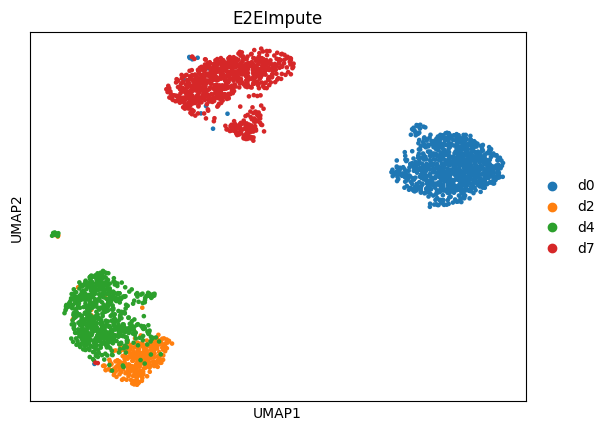

In [74]:
sc.pl.umap(adata_pred, color=['label'], title='E2EImpute', frameon=True)

In [75]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(adata_pred.obsm['X_umap'],kmeans.labels_)

In [76]:
print("mse: ", mse)
print("mae: ", mae)
print("pcc: ", pcc)
print("cs: ", cs)
print("ari: ", ari)
print("nmi: ", nmi)
print("silhouette score: ", sil_score)

mse:  3.4068
mae:  0.813
pcc:  0.8998
cs:  0.9139
ari:  0.8191
nmi:  0.8112
silhouette score:  0.6620013


### Save imputed data to disk

In [39]:
result.cpu().numpy().shape, result.cpu().numpy().dtype

((2713, 2000), dtype('float32'))

In [40]:
import scipy.io as sio
from scipy.sparse import csr_matrix 

In [41]:
sio.mmwrite('./predicted_data/my_model/klein/klein00_top2000_e2eimpute.mtx',csr_matrix(result.cpu().numpy().T))